In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [3]:
data = load_breast_cancer()
X = data.data
y = data.target

In [4]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [8]:
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

In [10]:
input_size = X_train.shape[1]
model = ANN(input_size)

In [11]:
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
import matplotlib.pyplot as plt


num_epochs = 100  
best_loss = np.inf
early_stop_count = 0
patience = 10 
train_losses = []
val_losses = []


In [15]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  
    
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)  
    
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f}")

   
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_ann_model.pth")  # Save best model
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/100 - Loss: 0.6826 - Val Loss: 0.6484
Epoch 2/100 - Loss: 0.5440 - Val Loss: 0.3317
Epoch 3/100 - Loss: 0.2135 - Val Loss: 0.0921
Epoch 4/100 - Loss: 0.1188 - Val Loss: 0.1036
Epoch 5/100 - Loss: 0.1011 - Val Loss: 0.0909
Epoch 6/100 - Loss: 0.0862 - Val Loss: 0.1311
Epoch 7/100 - Loss: 0.0782 - Val Loss: 0.0847
Epoch 8/100 - Loss: 0.0780 - Val Loss: 0.1210
Epoch 9/100 - Loss: 0.0776 - Val Loss: 0.1045
Epoch 10/100 - Loss: 0.0599 - Val Loss: 0.0655
Epoch 11/100 - Loss: 0.0708 - Val Loss: 0.0692
Epoch 12/100 - Loss: 0.0514 - Val Loss: 0.0904
Epoch 13/100 - Loss: 0.0516 - Val Loss: 0.0630
Epoch 14/100 - Loss: 0.0491 - Val Loss: 0.0504
Epoch 15/100 - Loss: 0.0438 - Val Loss: 0.0540
Epoch 16/100 - Loss: 0.0382 - Val Loss: 0.0554
Epoch 17/100 - Loss: 0.0358 - Val Loss: 0.0556
Epoch 18/100 - Loss: 0.0361 - Val Loss: 0.0634
Epoch 19/100 - Loss: 0.0379 - Val Loss: 0.0517
Epoch 20/100 - Loss: 0.0371 - Val Loss: 0.0525
Epoch 21/100 - Loss: 0.0396 - Val Loss: 0.0508
Epoch 22/100 - Loss: 0

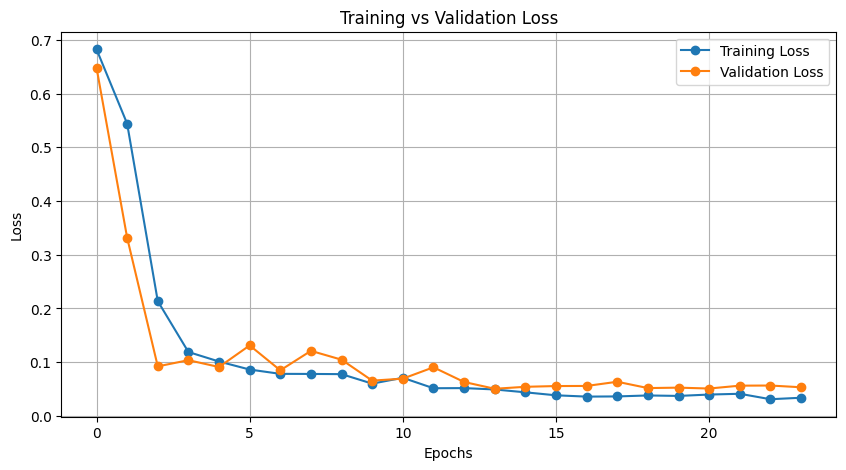

In [16]:

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", marker='o')
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:

model.load_state_dict(torch.load("best_ann_model.pth"))


model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_val, y_val in test_loader:
        y_pred = model(X_val)
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_val).sum().item()
        total += y_val.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9825


<ipython-input-17-4c5a4cb24c50>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_ann_model.pth"))


In [18]:

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = (predictions > 0.5).float()


print("First 5 Predictions:", predictions[:5].flatten().tolist())


First 5 Predictions: [1.0, 0.0, 0.0, 1.0, 1.0]


In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

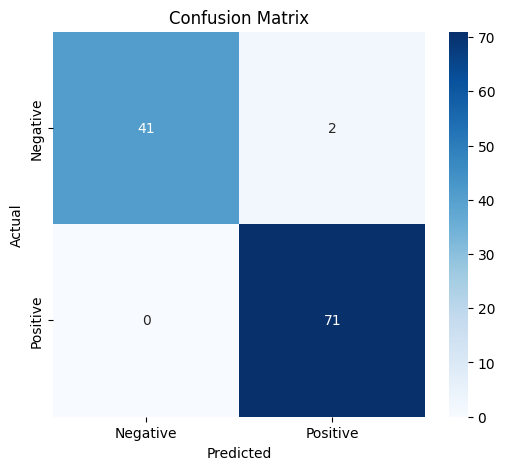

In [21]:

model.eval()
y_pred = model(X_test_tensor).detach().numpy()
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       1.00      0.95      0.98        43
    Positive       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

